<a href="https://colab.research.google.com/github/sruthibhavana/Deep_vision_crowd-project/blob/main/2newown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [121]:
!pip install -q torch torchvision torchaudio
!pip install -q opencv-python matplotlib

In [122]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [123]:
!unzip /content/drive/MyDrive/DeepVision_CrowdMonitor/shaghaiTech.zip.zip -d /content/

Archive:  /content/drive/MyDrive/DeepVision_CrowdMonitor/shaghaiTech.zip.zip
replace /content/ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_1.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_1.mat  
  inflating: /content/ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_10.mat  
  inflating: /content/ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_100.mat  
  inflating: /content/ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_101.mat  
  inflating: /content/ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_102.mat  
  inflating: /content/ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_103.mat  
  inflating: /content/ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_104.mat  
  inflating: /content/ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_105.mat  
  inflating: /content/ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_106.mat  
  inflating: /content/ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_10

In [124]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from scipy.io import loadmat
import torchvision.transforms as transforms
from cv2 import resize
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [125]:
train_dataset = CrowdDataset("/content/ShanghaiTech/part_A/train_data", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)

Total images found: 300


In [126]:
images, density_maps = next(iter(train_loader))
print(f"Batch image shape: {images.shape}")
print(f"Batch density map shape: {density_maps.shape}")

Batch image shape: torch.Size([4, 3, 512, 512])
Batch density map shape: torch.Size([4, 1, 512, 512])


In [ ]:
import torch.nn as nn
import torch.optim as optim
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1)
        )
    def forward(self, x):
        return self.features(x)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
for batch_idx, (images, density_maps) in enumerate(train_loader):
    images = images.to(device)
    density_maps = density_maps.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, density_maps)
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
        print(f"Batch {batch_idx}, Loss: {loss.item():.6f}")


Batch 0, Loss: 0.009174
Batch 10, Loss: 0.005219
Batch 20, Loss: 0.003758
Batch 30, Loss: 0.002474
Batch 40, Loss: 0.004339
Batch 50, Loss: 0.002721
Batch 60, Loss: 0.003736
Batch 70, Loss: 0.002061


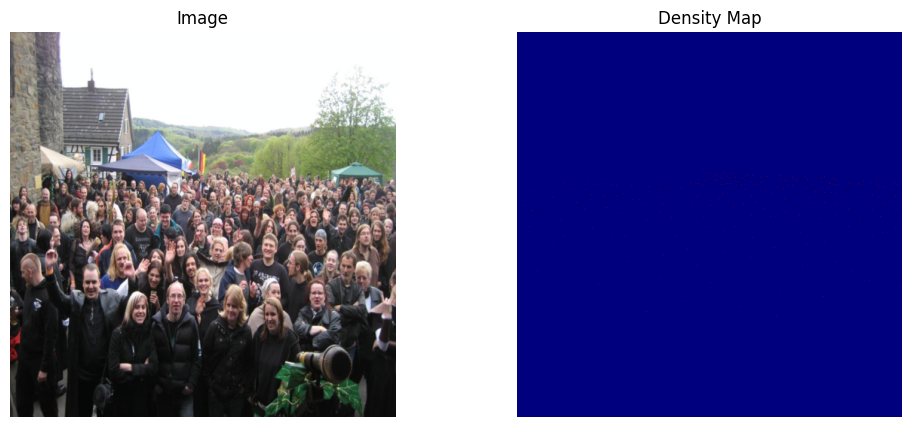

Total people (approx): 209.0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
images, density_maps = next(iter(train_loader))
img = images[0].permute(1, 2, 0).numpy()
img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
img = np.clip(img, 0, 1)
density_map = density_maps[0][0].numpy().astype(np.float32)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(density_map, cmap='jet')
plt.title("Density Map")
plt.axis("off")
plt.show()
print("Total people (approx):", np.sum(density_map))


In [127]:
# Save trained model weights
torch.save(model.state_dict(), "model.pth")
print("Model saved as model.pth")


Model saved as model.pth


In [128]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from email.message import EmailMessage
import smtplib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()
video_path = "/content/sample_video.mp4"
cap = cv2.VideoCapture(video_path)
crowd_threshold = 200
alert_sent = False
EMAIL_ADDRESS = "adhispidey007@gmail.com"
EMAIL_PASSWORD = "Aditya007"
RECEIVER_EMAIL = "receiver_email@gmail.com"
def send_email_alert(count):
    msg = EmailMessage()
    msg['Subject'] = "Overcrowding Alert!"
    msg['From'] = EMAIL_ADDRESS
    msg['To'] = RECEIVER_EMAIL
    msg.set_content(f"Alert! Current crowd count: {int(count)} exceeds threshold.")
    with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp:
        smtp.login(EMAIL_ADDRESS, EMAIL_PASSWORD)
        smtp.send_message(msg)
    print("Alert email sent!")
def preprocess_frame(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_resized = cv2.resize(frame_rgb, (512, 512))
    frame_normalized = frame_resized / 255.0
    frame_normalized = (frame_normalized - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
    frame_transposed = np.transpose(frame_normalized, (2, 0, 1))
    tensor = torch.from_numpy(frame_transposed).unsqueeze(0).float()
    return tensor.to(device)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    input_tensor = preprocess_frame(frame)
    with torch.no_grad():
        density_map = model(input_tensor)
    density_map_np = density_map.squeeze().cpu().numpy()
    crowd_count = np.sum(density_map_np)
    density_map_resized = cv2.resize(density_map_np, (frame.shape[1], frame.shape[0]))
    density_map_colored = cv2.applyColorMap((density_map_resized*255).astype(np.uint8), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(frame, 0.6, density_map_colored, 0.4, 0)
    if crowd_count > crowd_threshold:
        text = f"Crowd: {int(crowd_count)} - ALERT!"
        color = (0, 0, 255)
        if not alert_sent:
            send_email_alert(crowd_count)
            alert_sent = True
    else:
        text = f"Crowd: {int(crowd_count)}"
        color = (0, 255, 0)
        alert_sent = False
    cv2.putText(overlay, text, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    clear_output(wait=True)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    display(plt.gcf())
cap.release()
plt.close()

In [129]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from email.message import EmailMessage
import smtplib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()
video_path = "/content/sample_video.mp4"
cap = cv2.VideoCapture(video_path)
crowd_threshold = 200
alert_sent = False
EMAIL_ADDRESS = "_email@gmail.com"
EMAIL_PASSWORD = "_app_password"
RECEIVER_EMAIL = "receiver_email@gmail.com"
def send_email_alert(count):
    msg = EmailMessage()
    msg['Subject'] = "Overcrowding Alert!"
    msg['From'] = EMAIL_ADDRESS
    msg['To'] = RECEIVER_EMAIL
    msg.set_content(f"Alert! Current crowd count: {int(count)} exceeds threshold.")
    with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp:
        smtp.login(EMAIL_ADDRESS, EMAIL_PASSWORD)
        smtp.send_message(msg)
    print("Alert email sent!")
def preprocess_frame(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_resized = cv2.resize(frame_rgb, (512, 512))
    frame_normalized = frame_resized / 255.0
    frame_normalized = (frame_normalized - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
    frame_transposed = np.transpose(frame_normalized, (2, 0, 1))
    tensor = torch.from_numpy(frame_transposed).unsqueeze(0).float()
    return tensor.to(device)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    input_tensor = preprocess_frame(frame)
    with torch.no_grad():
        density_map = model(input_tensor)
    density_map_np = density_map.squeeze().cpu().numpy()
    crowd_count = np.sum(density_map_np)
    density_map_resized = cv2.resize(density_map_np, (frame.shape[1], frame.shape[0]))
    density_map_colored = cv2.applyColorMap((density_map_resized*255).astype(np.uint8), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(frame, 0.6, density_map_colored, 0.4, 0)
    if crowd_count > crowd_threshold:
        text = f"Crowd: {int(crowd_count)} - ALERT!"
        color = (0, 0, 255)
        if not alert_sent:
            send_email_alert(crowd_count)
            alert_sent = True
    else:
        text = f"Crowd: {int(crowd_count)}"
        color = (0, 255, 0)
        alert_sent = False
    cv2.putText(overlay, text, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    clear_output(wait=True)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    display(plt.gcf())
cap.release()
plt.close()

In [147]:
# new for dashboard refer
%%writefile app.py
import streamlit as st
import torch
import torch.nn as nn
import numpy as np
import cv2
from PIL import Image
import smtplib
from email.message import EmailMessage
class CrowdCNN(nn.Module):
    def __init__(self):
        super(CrowdCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1)
        )
    def forward(self, x):
        return self.features(x)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CrowdCNN().to(device)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()
EMAIL_ADDRESS = "@gmail.com"
EMAIL_PASSWORD = "password"
crowd_threshold = 200
def send_email_alert(count):
    msg = EmailMessage()
    msg['Subject'] = " Overcrowding Alert!"
    msg['From'] = EMAIL_ADDRESS
    msg['To'] = "@gmail.com"
    msg.set_content(f"Alert! Crowd count {int(count)} exceeds threshold.")
    with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp:
        smtp.login(EMAIL_ADDRESS, EMAIL_PASSWORD)
        smtp.send_message(msg)
def preprocess_image(image):
    img = np.array(image)
    if img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    img_resized = cv2.resize(img, (512, 512))
    img_resized = img_resized / 255.0
    img_resized = (img_resized - np.array([0.485,0.456,0.406])) / np.array([0.229,0.224,0.225])
    img_resized = np.transpose(img_resized, (2,0,1))
    tensor = torch.from_numpy(img_resized).unsqueeze(0).float()
    return tensor.to(device), img
st.set_page_config(page_title="DeepVision Crowd Monitor", layout="wide")
st.sidebar.title("⚙️ Controls")
uploaded_file = st.sidebar.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])
trigger = st.sidebar.button(" Estimate Crowd")
st.title("📊 DeepVision Crowd Monitor")
st.write("Upload an image to estimate crowd count and visualize density map.")
if "alert_sent" not in st.session_state:
    st.session_state.alert_sent = False
if uploaded_file is not None and trigger:
    image = Image.open(uploaded_file)
    input_tensor, original_image = preprocess_image(image)
    with torch.no_grad():
        density_map = model(input_tensor)
    density_map_np = density_map.squeeze().cpu().numpy()
    density_map_np = np.clip(density_map_np, 0, None)
    crowd_count = np.sum(density_map_np)
    density_map_resized = cv2.resize(density_map_np, (original_image.shape[1], original_image.shape[0]))
    density_map_colored = cv2.applyColorMap((density_map_resized*255).astype(np.uint8), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(original_image, 0.6, density_map_colored, 0.4, 0)
    col1, col2 = st.columns(2)
    with col1:
        st.subheader("Uploaded Image")
        st.image(original_image, channels="RGB")
    with col2:
        st.subheader("Crowd Density Map")
        st.image(overlay, channels="RGB")
    st.metric(label="Estimated Crowd Count", value=int(crowd_count))
    if crowd_count > crowd_threshold:
        st.error(f"⚠️ Crowd exceeds threshold ({crowd_threshold})!")
        if not st.session_state.alert_sent:
            send_email_alert(crowd_count)
            st.success("✅ Alert email sent!")
            st.session_state.alert_sent = True

Overwriting app.py


In [131]:
!ngrok authtoken 33NEcdd0x9YNrMvkeDGVShxyntx_c3swvhsXTbpVT5EoJEpX

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [132]:
!pip install streamlit --quiet

In [151]:
from pyngrok import ngrok
ngrok.kill()
!nohup streamlit run app.py > streamlit.log 2>&1 &


In [152]:
public_url = ngrok.connect(8501)
print("Your public URL:", public_url)


Your public URL: NgrokTunnel: "https://semihistoric-unannoyed-merlin.ngrok-free.dev" -> "http://localhost:8501"
